## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

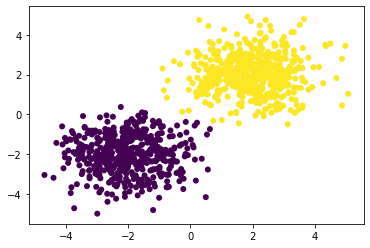

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

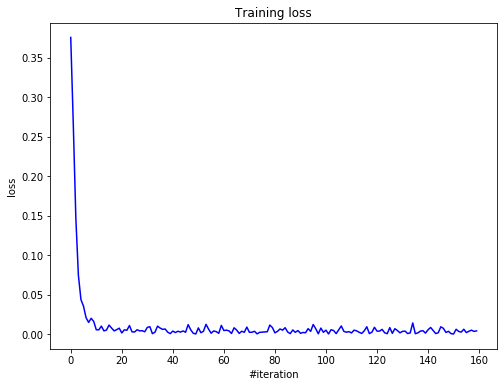

Current loss: 0.004122


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
def ohe(input, classes=10):
    encoded_targets = np.eye(classes)[input]
    return encoded_targets

In [10]:
y_train = ohe(y_train)
y_val = ohe(y_val)
y_test = ohe(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
def quality(y_pred, y_real):
    pred = y_pred.argmax(axis=-1)
    label = y_real.argmax(axis=-1)
    return np.mean(pred == label)


def train_(net, criterion, X, y, batch_size, optimizer_config, optimizer_state, optimizer):
    for x_batch, y_batch in get_batches((X, y), batch_size):
        net.zeroGradParameters()
        # Forward
        preds = net.forward(x_batch)
        # Backward
        dp = criterion.backward(preds, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        optimizer(net.getParameters(), 
                  net.getGradParameters(), 
                  optimizer_config,
                  optimizer_state)
    predictions = net.forward(X)
    return criterion.forward(predictions, y), quality(predictions, y)

In [12]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.99, 'epsilon': 10e-6}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [13]:
np.random.seed(23)
# nets with different activation functions without BatchNormalization
# ReLU
net_ReLU = Sequential()
net_ReLU.add(Linear(28*28, 100))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(100, 200))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(200, 10))
net_ReLU.add(LogSoftMax())

# ELU
net_ELU = Sequential()
net_ELU.add(Linear(28*28, 100))
net_ELU.add(ELU())
net_ELU.add(Linear(100, 200))
net_ELU.add(ELU())
net_ELU.add(Linear(200, 10))
net_ELU.add(LogSoftMax())

# LeakyReLU
net_LeakyReLU = Sequential()
net_LeakyReLU.add(Linear(28*28, 100))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(100, 200))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(200, 10))
net_LeakyReLU.add(LogSoftMax())

# SoftPlus
net_SoftPlus = Sequential()
net_SoftPlus.add(Linear(28*28, 100))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(100, 200))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(200, 10))
net_SoftPlus.add(LogSoftMax())

# nets with different activation functions WITH BatchNormalization
# ReLU + BatchNormalization
net_ReLU_BN = Sequential()
net_ReLU_BN.add(Linear(28*28, 100))
net_ReLU_BN.add(BatchNormalization(alpha = 0.9))
net_ReLU_BN.add(ChannelwiseScaling(100))
net_ReLU_BN.add(ReLU())
net_ReLU_BN.add(Linear(100, 200))
net_ReLU_BN.add(ReLU())
net_ReLU_BN.add(Linear(200, 10))
net_ReLU_BN.add(LogSoftMax())

# ELU + BatchNormalization
net_ELU_BN = Sequential()
net_ELU_BN.add(Linear(28*28, 100))
net_ELU_BN.add(BatchNormalization(alpha = 0.9))
net_ELU_BN.add(ChannelwiseScaling(100))
net_ELU_BN.add(ELU())
net_ELU_BN.add(Linear(100, 200))
net_ELU_BN.add(ELU())
net_ELU_BN.add(Linear(200, 10))
net_ELU_BN.add(LogSoftMax())

# LeakyReLU + BatchNormalization
net_LeakyReLU_BN = Sequential()
net_LeakyReLU_BN.add(Linear(28*28, 100))
net_LeakyReLU_BN.add(BatchNormalization(alpha = 0.9))
net_LeakyReLU_BN.add(ChannelwiseScaling(100))
net_LeakyReLU_BN.add(LeakyReLU())
net_LeakyReLU_BN.add(Linear(100, 200))
net_LeakyReLU_BN.add(LeakyReLU())
net_LeakyReLU_BN.add(Linear(200, 10))
net_LeakyReLU_BN.add(LogSoftMax())

# SoftPlus + BatchNormalization
net_SoftPlus_BN = Sequential()
net_SoftPlus_BN.add(Linear(28*28, 100))
net_SoftPlus_BN.add(BatchNormalization(alpha = 0.9))
net_SoftPlus_BN.add(ChannelwiseScaling(100))
net_SoftPlus_BN.add(SoftPlus())
net_SoftPlus_BN.add(Linear(100, 200))
net_SoftPlus_BN.add(SoftPlus())
net_SoftPlus_BN.add(Linear(200, 10))
net_SoftPlus_BN.add(LogSoftMax())

# ReLU with adam opt
net_ReLU_adam = Sequential()
net_ReLU_adam.add(Linear(28*28, 100))
net_ReLU_adam.add(ReLU())
net_ReLU_adam.add(Linear(100, 200))
net_ReLU_adam.add(ReLU())
net_ReLU_adam.add(Linear(200, 10))
net_ReLU_adam.add(LogSoftMax())

In [14]:
nns = {'ReLU' : {'net' : net_ReLU,
                 'criterion' : ClassNLLCriterion(),
                 'optimazer_state' : {},
                 'train_loss': [],
                 'val_loss': [],
                 'test_loss' : [],
                 'train_acc': [],
                 'val_acc': [],
                 'test_acc' : [],
                 'execution_time': 0,
                 'optimizer' : sgd_momentum},
       'ELU':   {'net' : net_ELU,
                  'criterion' : ClassNLLCriterion(),
                  'optimazer_state' : {},
                  'train_loss': [],
                  'val_loss': [],
                  'test_loss' : [],
                  'train_acc': [],
                  'val_acc': [],
                  'test_acc' : [],
                  'execution_time': 0,
                  'optimizer' : sgd_momentum},
        'LeakyReLU':  {'net' : net_LeakyReLU,
                       'criterion' : ClassNLLCriterion(),
                       'optimazer_state' : {},
                       'train_loss': [],
                       'val_loss': [],
                       'test_loss' : [],
                       'train_acc': [],
                       'val_acc': [],
                       'test_acc' : [],
                       'execution_time': 0,
                       'optimizer': sgd_momentum},
        'SoftPlus': {'net' : net_SoftPlus,
                     'criterion' : ClassNLLCriterion(),
                     'optimazer_state' : {},
                     'train_loss': [],
                     'val_loss': [],
                     'test_loss' : [],
                     'train_acc': [],
                     'val_acc': [],
                     'test_acc' : [],
                     'execution_time': 0,
                     'optimizer' : sgd_momentum},
       'ReLUBN' : {'net' : net_ReLU_BN,
                   'criterion' : ClassNLLCriterion(),
                   'optimazer_state' : {},
                   'train_loss': [],
                   'val_loss': [],
                   'test_loss' : [],
                   'train_acc': [],
                   'val_acc': [],
                   'test_acc' : [],
                   'execution_time': 0,
                   'optimizer' : sgd_momentum},
       'ELUBN':   {'net' : net_ELU_BN,
                   'criterion' : ClassNLLCriterion(),
                   'optimazer_state' : {},
                   'train_loss': [],
                   'val_loss': [],
                   'test_loss' : [],
                   'train_acc': [],
                   'val_acc': [],
                   'test_acc' : [],
                   'execution_time': 0,
                   'optimizer' : sgd_momentum},
       'LeakyReLUBN':  {'net' : net_LeakyReLU_BN,
                        'criterion' : ClassNLLCriterion(),
                        'optimazer_state' : {},
                        'train_loss': [],
                        'val_loss': [],
                        'test_loss' : [],
                        'train_acc': [],
                        'val_acc': [],
                        'test_acc' : [],
                        'execution_time': 0,
                        'optimizer': sgd_momentum},
      'SoftPlusBN': {'net' : net_SoftPlus_BN,
                     'criterion' : ClassNLLCriterion(),
                     'optimazer_state' : {},
                     'train_loss': [],
                     'val_loss': [],
                     'test_loss' : [],
                     'train_acc': [],
                     'val_acc': [],
                     'test_acc' : [],
                     'execution_time': 0,
                     'optimizer' : sgd_momentum},
       'ReLU_adam':  {'net' : net_ReLU_adam,
                       'criterion' : ClassNLLCriterion(),
                       'optimazer_state' : {},
                       'train_loss': [],
                       'val_loss': [],
                       'test_loss' : [],
                       'train_acc': [],
                       'val_acc': [],
                       'test_acc' : [],
                       'execution_time': 0,
                       'optimizer': adam_optimizer}
      }

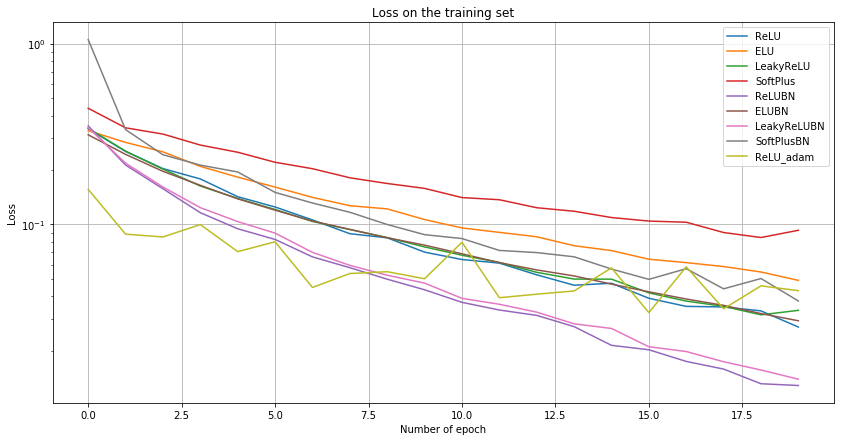

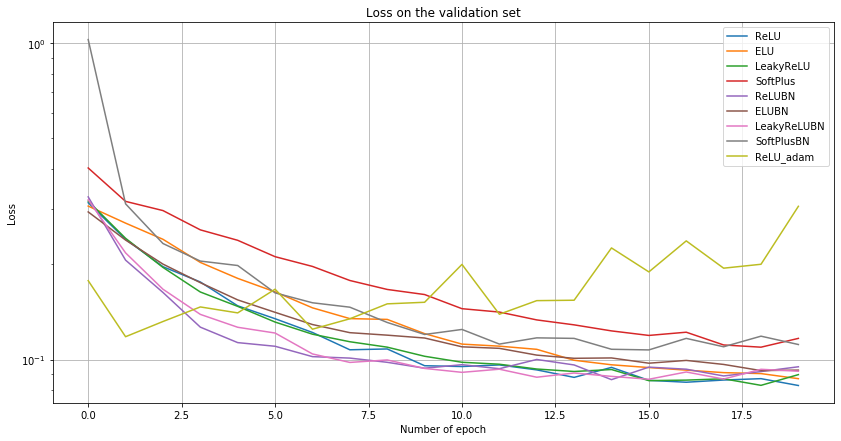

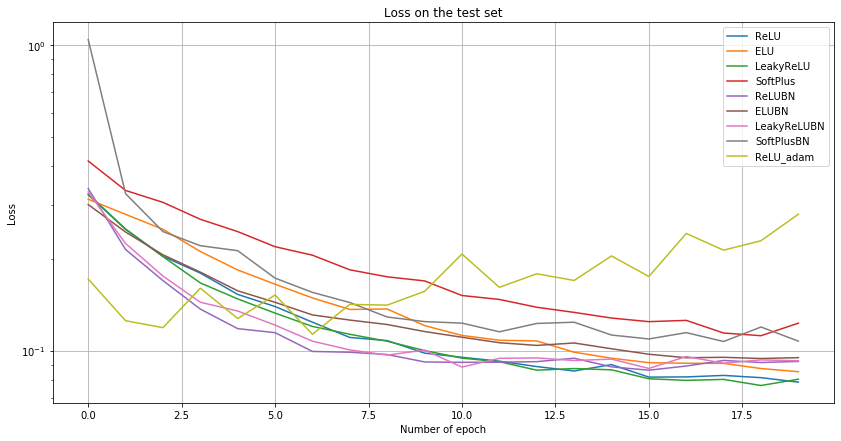

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [18:06<00:00, 54.34s/it]


In [15]:
np.random.seed(101)

for _ in tqdm(range(n_epoch)):
    for net in nns:
        start = time()
        loss, acc = train_(nns[net]['net'], nns[net]['criterion'], X_train, y_train,
                           batch_size, optimizer_config, nns[net]['optimazer_state'], 
                           nns[net]['optimizer'])
        end = time()

        nns[net]['execution_time'] += (end - start)
        nns[net]['train_loss'].append(loss)
        nns[net]['train_acc'].append(acc)
        
        predictions_val = nns[net]['net'].forward(X_val)
        nns[net]['val_loss'].append(nns[net]['criterion'].forward(predictions_val, y_val))
        nns[net]['val_acc'].append(quality(predictions_val, y_val))

        predictions_test = nns[net]['net'].forward(X_test)
        nns[net]['test_loss'].append(nns[net]['criterion'].forward(predictions_test, y_test))
        nns[net]['test_acc'].append(quality(predictions_test, y_test))

    display.clear_output(wait=True)
    # Train loss plot
    plt.figure(figsize=(14, 7))  
    plt.title('Loss on the training set')
    plt.xlabel('Number of epoch')
    plt.ylabel('Loss')
    for net in nns:
        plt.semilogy(nns[net]['train_loss'], label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Validation loss plot
    plt.figure(figsize=(14, 7)) 
    plt.title('Loss on the validation set')
    plt.xlabel('Number of epoch')
    plt.ylabel('Loss')
    for net in nns:
        plt.semilogy(nns[net]['val_loss'], label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Test loss plot
    plt.figure(figsize=(14, 7)) 
    plt.title('Loss on the test set')
    plt.xlabel('Number of epoch')
    plt.ylabel('Loss')
    for net in nns:
        plt.semilogy(nns[net]['test_loss'], label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()  

In [16]:
def summary(dict_with_nn_data):
    df = pd.DataFrame(columns=['NN', 'train_loss', 'val_loss', 'test_loss', 'train_acc', 'val_acc', 'test_acc',
                               'execution_time'])
    count = 0
    for net in dict_with_nn_data:
        row = []
        row.append(net)
        row.append(round(dict_with_nn_data[net]['train_loss'][-1], 3))
        row.append(round(dict_with_nn_data[net]['val_loss'][-1], 3))
        row.append(round(dict_with_nn_data[net]['test_loss'][-1], 3))
        row.append(round(dict_with_nn_data[net]['train_acc'][-1], 3) * 100)
        row.append(round(dict_with_nn_data[net]['val_acc'][-1], 3) * 100)
        row.append(round(dict_with_nn_data[net]['test_acc'][-1], 3) * 100)
        row.append(round(dict_with_nn_data[net]['execution_time'], 3))
        df.loc[count] = row
        count+=1
    return df

In [17]:
summary(nns)

,NN,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc,execution_time
0,ReLU,0.027,0.083,0.079,99.4,97.6,97.6,86.605
1,ELU,0.049,0.087,0.085,98.6,97.6,97.4,107.189
2,LeakyReLU,0.034,0.090,0.081,99.1,97.5,97.6,82.594
3,SoftPlus,0.093,0.117,0.123,97.2,96.8,96.2,121.547
4,ReLUBN,0.013,0.095,0.092,99.7,97.4,97.4,94.014
5,ELUBN,0.029,0.093,0.095,99.2,97.5,97.3,111.668
6,LeakyReLUBN,0.014,0.092,0.093,99.7,97.5,97.6,94.274
7,SoftPlusBN,0.038,0.112,0.107,98.9,96.8,97.1,130.209
8,ReLU_adam,0.043,0.305,0.279,99.2,97.4,97.4,95.963


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

From the table above it can be seen that LeakyReLU and ReLU has the shortest execution time and the quaity of this problem classification is high. ReLU can have troubles on other tasks due to "dying ReLU" problem, but LeakyReLU fixes that problem.
BatchNormalization provides better train losses and scores for all 4 nets but it adds to computational time.
ReLU with sgd performs better than with adam on this task

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [20]:
# Your code goes here. ################################################

DEFAULT_LEARNING_RATE = 1e-1
gamma = 0.9
n_epoch = 30
learning_rate = [DEFAULT_LEARNING_RATE * gamma ** epoch for epoch in range(n_epoch)]

optimizer_state = {}

# Looping params
batch_size = 128

net_DROPOUT = Sequential()
net_DROPOUT.add(Linear(28*28, 100))
net_DROPOUT.add(BatchNormalization(alpha = 0.9))
net_DROPOUT.add(ChannelwiseScaling(100))
net_DROPOUT.add(Dropout(0.5))
net_DROPOUT.add(ReLU())
net_DROPOUT.add(Linear(100, 200))
net_DROPOUT.add(BatchNormalization(alpha = 0.9))
net_DROPOUT.add(ChannelwiseScaling(200))
net_DROPOUT.add(Dropout(0.5))
net_DROPOUT.add(ReLU())
net_DROPOUT.add(Linear(200, 10))
net_DROPOUT.add(LogSoftMax())

net = {'DROPOUT' : {'net' : net_DROPOUT,
                     'criterion' : ClassNLLCriterion(),
                     'optimazer_state' : {},
                     'train_loss': [],
                     'val_loss': [],
                     'test_loss' : [],
                     'train_acc': [],
                     'val_acc': [],
                     'test_acc' : [],
                     'execution_time': 0,
                     'optimizer' : sgd_momentum}}

In [21]:
np.random.seed(101)
# Train the net
for i in tqdm(range(n_epoch)):
    optimizer_config = {'learning_rate': learning_rate[i], 'momentum': 0.9}
    start = time()
    loss, acc = train_(net['DROPOUT']['net'], net['DROPOUT']['criterion'], X_train, y_train,
                       batch_size, optimizer_config, net['DROPOUT']['optimazer_state'],
                       net['DROPOUT']['optimizer'])
    end = time()
    
    
    net['DROPOUT']['execution_time'] += (end - start)
    net['DROPOUT']['train_loss'].append(loss)
    net['DROPOUT']['train_acc'].append(acc)
    preds_val = net['DROPOUT']['net'].forward(X_val)
    net['DROPOUT']['val_loss'].append(net['DROPOUT']['criterion'].forward(preds_val, y_val))
    net['DROPOUT']['val_acc'].append(quality(preds_val, y_val))
    preds_test = net['DROPOUT']['net'].forward(X_test)
    net['DROPOUT']['test_loss'].append(net['DROPOUT']['criterion'].forward(preds_test, y_test))
    net['DROPOUT']['test_acc'].append(quality(preds_test, y_test))



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:05<00:00,  8.18s/it]


Print here your accuracy on test set. It should be around 90%.

In [22]:
print(f"Accuracy on train set is {net['DROPOUT']['train_acc'][-1]}")
print(f"Accuracy on test set is {net['DROPOUT']['test_acc'][-1]}")

Accuracy on train set is 0.95632
Accuracy on test set is 0.9437


Dropout really helps with overfitting problem and it can be seen that with dropout quality on train and test set are much closer than for the nets of the same architecture but without dropout checked above. Same goes for losses.

Learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, so I increased number of epoch for this net compared to the ones above. The idea behind udaptable learning rate is to avoid too fast convergence to a suboptimal solution. It seems to me together with Dropout it worked good and provided closer results for train and test sets.

In [23]:
print(f"Loss on train set is {net['DROPOUT']['train_loss'][-1]}")
print(f"Loss on test set is {net['DROPOUT']['test_loss'][-1]}")

Loss on train set is 0.1459935069619097
Loss on test set is 0.19236008526346357


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [24]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [26]:
root_path = 'mnist'
download = True
train_transform = transforms.ToTensor()
val_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


mnist_dataset_train = torchvision.datasets.MNIST(root_path, 
                                                 train=True, 
                                                 transform=train_transform,
                                                 target_transform=None,
                                                 download=download)
mnist_dataset_val = torchvision.datasets.MNIST(root_path, 
                                               train=False, 
                                               transform=val_transform,
                                               target_transform=None,
                                               download=download)
mnist_dataset_test = torchvision.datasets.MNIST(root_path, 
                                                train=False, 
                                                transform=test_transform,
                                                target_transform=None,
                                                download=download)

In [27]:
train_loader = torch.utils.data.DataLoader(mnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_dataset_val,
                                         batch_size=256,
                                         shuffle=False,
                                         num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [28]:
class DropoutNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
             nn.Linear(input_shape, 100),
             nn.BatchNorm1d(100, momentum = 0.1),
             nn.Dropout(p=0.5),
             nn.ReLU(),
             nn.Linear(100, 200),
             nn.BatchNorm1d(200, momentum = 0.1),
             nn.Dropout(p=0.5),
             nn.ReLU(),
             nn.Linear(200, num_classes),
             nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [29]:
model = DropoutNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_func =  nn.NLLLoss()

In [30]:
def train_save_loss_score(model, train_loader, val_loader, test_loader, loss_fn, optimizer, n_epoch, scheduler):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(n_epoch):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_test_loss = []
        ep_test_accuracy = []
        model.train(True)        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(accuracy_score(np.argmax(preds.detach().numpy(), axis=1), y_batch.detach().numpy()))
        scheduler.step()
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)                
                ep_val_loss.append(loss_func(preds, y_batch.long()).item())
                ep_val_accuracy.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)                
                ep_test_loss.append(loss_func(preds, y_batch.long()).item())
                ep_test_accuracy.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy)) 
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))
    return train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy

In [31]:
train_loss, train_accuracy,  val_loss, val_accuracy, test_loss, test_accuracy = train_save_loss_score(model, 
                                                                                                     train_loader, 
                                                                                                     val_loader, 
                                                                                                     test_loader, 
                                                                                                     loss_func, 
                                                                                                     optimizer, 
                                                                                                     n_epoch, 
                                                                                                     scheduler)

In [32]:
print(f"Accuracy on test set is {test_accuracy[-1]}")

Accuracy on test set is 0.97734375
